<div style="text-align:center;font-size:22pt; font-weight:bold;color:white;border:solid black 1.5pt;background-color:#1e7263;">
        Understanding the ReduceLROnPlateau Callback in Keras: House Price Dataset (Regression Task)
</div>

In [1]:
# ======================================================================= #
# Course: Deep Learning Complete Course (CS-501)
# Author: Dr. Saad Laouadi
# Institution: Quant Coding Versity Academy
# Date: January 7, 2025
#
# ==========================================================
# Lesson: Learning Rate Adaptation with ReduceLROnPlateau
#         House Price Dataset (Regression Analysis)
# ==========================================================
# ## Learning Objectives
# This lesson will enable you to:
# 1. Understand regression tasks using the House Price Dataset
# 2. Implement ReduceLROnPlateau callback in Keras
# 3. Configure and optimize callback parameters for regression
# 4. Monitor learning rate adjustments during model training
# 5. Analyze the impact of adaptive learning rates on price predictions
# 6. Compare model performance with static vs adaptive learning rates
# =======================================================================
#          Copyright © Dr. Saad Laouadi 2025
# =======================================================================

In [2]:
# ==================================================== #
#        Load Required Libraries
# ==================================================== #

import os  
import shutil
from datetime import datetime

# Disable Metal API Validation
os.environ["METAL_DEVICE_WRAPPER_TYPE"] = "0"  


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# import tensorflow
import tensorflow as tf

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Set styling for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("="*72)

%reload_ext watermark
%watermark -a "Dr. Saad Laouadi" -u -d -m

print("="*72)
print("Imported Packages and Their Versions:")
print("="*72)

%watermark -iv
print("="*72)

# Global Config
RANDOM_STATE = 101

Author: Dr. Saad Laouadi

Last updated: 2025-01-07

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 24.1.0
Machine     : arm64
Processor   : arm
CPU cores   : 16
Architecture: 64bit

Imported Packages and Their Versions:
seaborn   : 0.13.2
pandas    : 2.2.2
tensorflow: 2.16.2
keras     : 3.6.0
sklearn   : 1.5.1
numpy     : 1.26.4
matplotlib: 3.9.2



In [3]:
# =============================================================================
# Educational Utility Function: Directory Cleanup
# =============================================================================
#
# Purpose:
#   This utility function is designed for educational purposes in the context
#   of programming tutorials and exercises. It provides a safe way to clean up
#   working directories during course activities.
#
# Usage Context:
#   - Instructors: Useful for preparing and resetting educational content
#   - Students: Helpful when experimenting with code examples
#   - Learning Environment: Supports clean workspace management
#
# Note:
#   This function is intended for educational environments only and should be
#   used with caution as it permanently deletes directory contents.
# =============================================================================

def cleanup_directory(directory_path):
    """
    Deletes the specified directory and all its contents.
    Args:
        directory_path (str): Path to the directory to delete.
    """
    if os.path.exists(directory_path) and os.path.isdir(directory_path):
        shutil.rmtree(directory_path)
        print(f"Directory '{os.path.basename(directory_path)}' deleted successfully.")
    else:
        print(f"Directory '{os.path.basename(directory_path)}' does not exist or is not a directory.")

### Lecture Raodmap
1. Load the data
2. Explore the data
3. Process the data
4. Build the model
5. Tune the model using Callbacks (ReduceLROnPlateau, EarlyStopping ...)
6. Analyze the results

In [4]:
# ================================================================= #
#          California House Prices Project
# ================================================================= #
# A function to load and process the data
def load_and_preprocess_data():
    """Load and preprocess the California Housing dataset"""
    # Load data
    housing = fetch_california_housing()
    X, y = housing.data, housing.target
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, housing.feature_names

In [5]:
# A function to create the model architecture
def create_model(input_shape, initial_lr=0.001):
    """Create a model with specified initial learning rate"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape = input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.1),
        
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Dense(1)
    ])
    
    model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=initial_lr),
        loss='mse',
        metrics=['mae']
    )
    
    return model

In [6]:
# A function to train the model with adaptive lr.
def train_with_lr_plateau():
    # Load and preprocess data
    X_train, X_test, y_train, y_test, feature_names = load_and_preprocess_data()
    
    # Create model with higher initial learning rate
    initial_lr = 0.01  # Start with higher learning rate
    model = create_model((X_train.shape[1],), initial_lr)
    
    # Create checkpoint directory
    checkpoint_dir = 'housing_model_checkpoints'
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    
    # Define callbacks
    lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,  # Reduce LR by half when plateauing
        patience=10,  # Wait for 10 epochs before reducing LR
        min_delta=0.0001,
        min_lr=1e-6,
        verbose=1
    )
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,  # Increased patience to allow LR reduction to take effect
        min_delta=0.0001,
        mode='min',
        restore_best_weights=True,
        verbose=1
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(checkpoint_dir, 'best_model.keras'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=200,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping, lr_reducer, checkpoint],
        verbose=1
    )
    
    
    return model, history, X_test, y_test

In [7]:
# Plotting function
def plot_training_history(history):
    """Plot training curves including learning rate changes"""
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
    
    # Plot loss
    ax1.plot(history.history['loss'], label='Training Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss (MSE)')
    ax1.legend()
    ax1.grid(True)
    
    # Plot MAE
    ax2.plot(history.history['mae'], label='Training MAE')
    ax2.plot(history.history['val_mae'], label='Validation MAE')
    ax2.set_title('Model Mean Absolute Error')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('MAE')
    ax2.legend()
    ax2.grid(True)
    
    # Plot Learning Rate
    ax3.plot(history.history['learning_rate'], label='Learning Rate')
    ax3.set_title('Learning Rate Over Time')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Learning Rate')
    ax3.set_yscale('log')  # Use log scale for better visualization
    ax3.legend()
    ax3.grid(True)
    
    plt.tight_layout()
    plt.show()

In [8]:
# Results Evaluation function
def evaluate_results(model, X_test, y_test, history):
    """Evaluate and print model results"""
    # Evaluate on test set
    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
    
    # Get training statistics
    best_epoch = np.argmin(history.history['val_loss']) + 1
    total_epochs = len(history.history['loss'])
    best_val_loss = min(history.history['val_loss'])
    best_val_mae = min(history.history['val_mae'])
    
    # Get learning rate statistics
    initial_lr = history.history['learning_rate'][0]
    final_lr = history.history['learning_rate'][-1]
    num_lr_drops = sum(1 for i in range(1, len(history.history['learning_rate']))
                      if history.history['learning_rate'][i] < history.history['learning_rate'][i-1])
    
    print("\nModel Performance Summary:")
    print("-" * 50)
    print(f"Best validation loss achieved at epoch: {best_epoch}/{total_epochs}")
    print(f"Best validation loss (MSE): {best_val_loss:.4f}")
    print(f"Best validation MAE: {best_val_mae:.4f}")
    print(f"Test loss (MSE): {test_loss:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print("\nLearning Rate Summary:")
    print(f"Initial learning rate: {initial_lr:.6f}")
    print(f"Final learning rate: {final_lr:.6f}")
    print(f"Number of learning rate reductions: {num_lr_drops}")
    print("-" * 50)

In [9]:
# ================================================================= #
#          Practice Part: Run the Code for House Prices Project
# ================================================================= #
# 1. Train model
model, history, X_test, y_test = train_with_lr_plateau()

Epoch 1/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.8119 - mae: 0.9554
Epoch 1: val_loss improved from inf to 0.55095, saving model to housing_model_checkpoints/best_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 1.8074 - mae: 0.9540 - val_loss: 0.5509 - val_mae: 0.5296 - learning_rate: 0.0100
Epoch 2/200
204/207 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.4584 - mae: 0.4946
Epoch 2: val_loss improved from 0.55095 to 0.47210, saving model to housing_model_checkpoints/best_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.4578 - mae: 0.4942 - val_loss: 0.4721 - val_mae: 0.4813 - learning_rate: 0.0100
Epoch 3/200
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4199 - mae: 0.4660
Epoch 3: val_loss improved from 0.47210 to 0.39046, saving model to housing_model_checkpoints/best_model.keras
207/207 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.4198 - mae: 0.4659 - val_loss: 0.3905 - val_mae: 0.4675 - learning_rate: 0.0100
Epoch 4/200
205/207 ━━━━━━

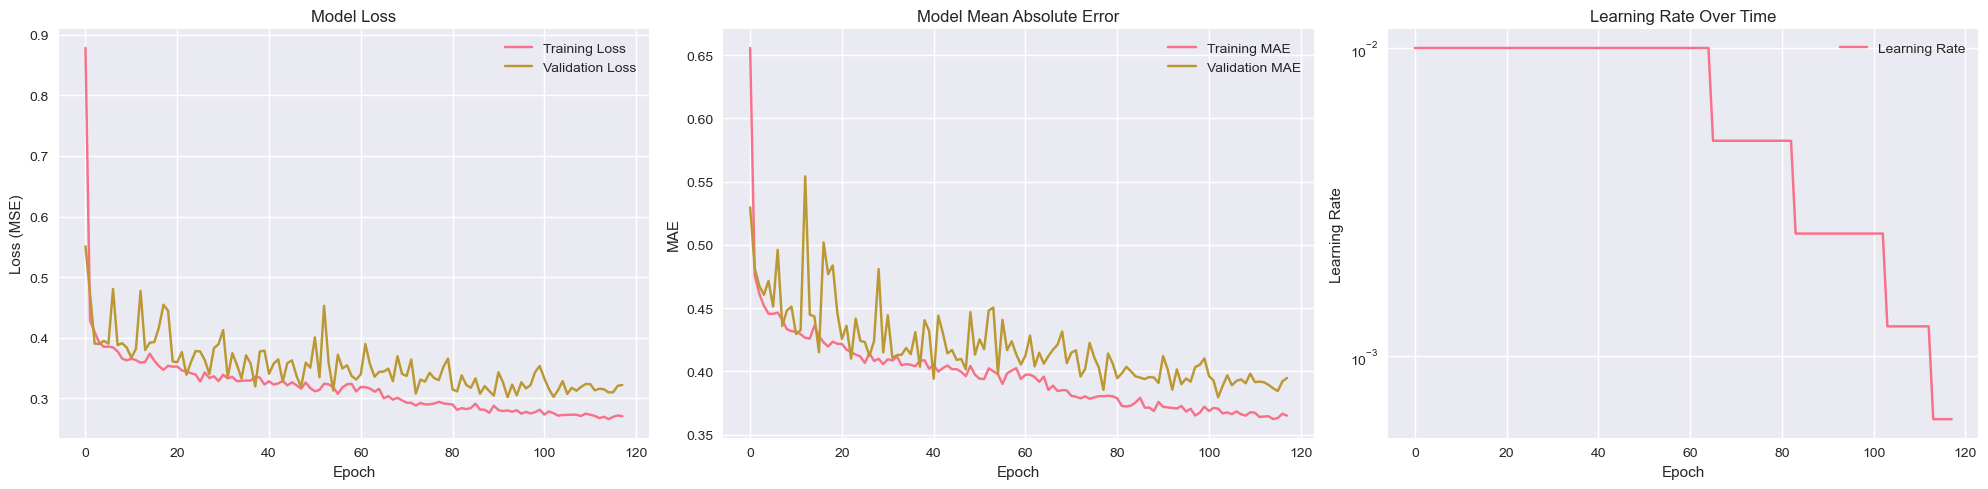

In [10]:
# 2. Plot results
plot_training_history(history)

In [11]:
# 3. Evaluate and print results
evaluate_results(model, X_test, y_test, history)


Model Performance Summary:
--------------------------------------------------
Best validation loss achieved at epoch: 93/118
Best validation loss (MSE): 0.3020
Best validation MAE: 0.3795
Test loss (MSE): 0.2921
Test MAE: 0.3766

Learning Rate Summary:
Initial learning rate: 0.010000
Final learning rate: 0.000625
Number of learning rate reductions: 4
--------------------------------------------------
